<a href="https://colab.research.google.com/github/anna-dang/mod05-capstone/blob/main/NLP_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hotel Review Classifier (working title)

*Flatiron School Data Science Bootcamp*

Captsone Project - NLP Sentiment/Ratings Analysis

Anna D'Angela | [annaadangela@gmail.com](mailto:annaadangela@gmail.com)

[Return to GitHub repo](https://github.com/anna-dang/mod05-capstone) 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/anna-dang/mod05-capstone/blob/main/NLP_processing.ipynb)

<!-- FROM GITHUB: Replace "github.com" to "colab.research.google.com/github". 
For example, if the URL on GitHub is https://github.com/shoji9x9/train-yolov3-on-google-colaboratory/blob/master/Training.ipynb, it should be replaced to https://colab.research.google.com/github/shoji9x9/train-yolov3-on-google-colaboratory/blob/master/Training.ipynb.

FROM COLAB: Select File -> Open notebook...
Input the URL on GitHub (e.g. https://github.com/shoji9x9/train-yolov3-on-google-colaboratory/blob/master/Training.ipynb) into "Enter a GitHub URL or search by organization or user" on GITHUB tab.
 -->

In [1]:
# Colab flow:
# 1) upload 'clean_scrap.csv' and 'NLP_functions.py' into content/
# 2) import .py and read_csv
# NOTE: geonpandas and mapbox commented out, don't try to load the map/df

# Link to py file in Colab:
# Manually upload into content/drive or use this to open pop-up window
from google.colab import files
src = list(files.upload().values())[0]

Saving clean_scrape.csv to clean_scrape.csv


In [4]:
# Link to py file from path, then import as usual
open('/content/NLP_functions.py','wb').write(src)
import NLP_functions as nlp

# Save changes: 
# Push Colab to GitHub and pull that locally
# OR Download .ipynb and replace locally

# EDA TODO
- upgrade plot design
- organize libraries

In [ ]:
!pip install geopandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import plotly.express as px
# (for colab)import geopandas as gpd

import plotly.graph_objects as go
import pandas as pd
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from imblearn.under_sampling import RandomUnderSampler
import nltk
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


# My custome functions
#(hidden for Colab)from capstone_functions import NLP_functions as NLP
seed = 619

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Import data and explore

In [3]:
# import test data
# colab:
df_raw = pd.read_csv("clean_scrape.csv")
#(colab)df_raw = pd.read_csv("./data/clean_scrape.csv")
display(df_raw.head())

# check for null/value types
df_raw.info()

,Location,Hotel,Title,Review,Rating
0,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Great View,Easy check in and check out process using the ...,5
1,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Clean and Comfortable,We needed a last-minute place to stay in Denve...,5
2,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Excellent Staff & Service,We love Hyatt hotels and have had many great e...,5
3,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Trip to Denver - a Hallmark Christmas,"I have never encountered such helpful, friendl...",5
4,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Our 'see downtown' hotel,"We love it here! Great service, they usually r...",5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22217 entries, 0 to 22216
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Location  22217 non-null  object
 1   Hotel     22217 non-null  object
 2   Title     22217 non-null  object
 3   Review    22217 non-null  object
 4   Rating    22217 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 868.0+ KB


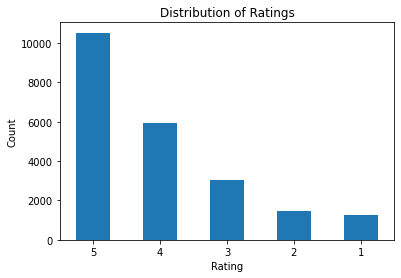

In [7]:
# Examine class distribution by count
df_raw['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

In [8]:
# Examine imbalance as percentage
percent = round(df_raw['Rating'].value_counts(1).to_frame(name='Percent %').rename_axis('Rating') * 100, 2)
percent

,Percent %
Rating,
5,47.36
4,26.66
3,13.62
2,6.69
1,5.67


There is a significant imbalance in classes. First I will randomly undersample the most major class, 5 by equalizing the amount with the second highest class, 4. This is to reduce the dimensions for the model by growing the total corpus largely positive.

In [9]:
tot_5 = df_raw[df_raw['Rating'] == 5].count()[0] 
tot_4 = df_raw[df_raw['Rating'] == 4].count()[0] 
drop_n = tot_5 - tot_4
drop_n

4600

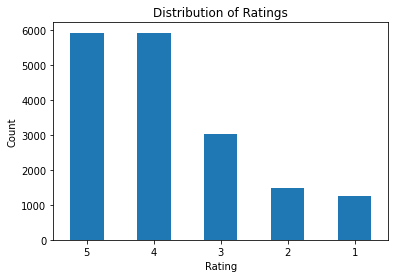

In [10]:
test = df_raw.drop(df_raw[df_raw['Rating'].eq(5)].sample(drop_n, random_state=seed).index)

# Examine class distribution by randomly reducing the most major class
test['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

Remaining class imbalance is less sever, I will address this by using class weights when modeling.

### Collection distribution

In [14]:
# Examine collection distribution by location
avg_df = df_raw.groupby(by = 'Hotel')[['Rating']].agg(['count', 'mean'])

coords = pd.read_csv("./data/coordinates.csv", names = ['Hotel', 'Lat', 'Long'])

map_df = pd.merge(avg_df, coords, on = 'Hotel')
map_df

,Hotel,"(Rating, count)","(Rating, mean)",Lat,Long
0,Baymont by Wyndham Denver International Airport,2094,3.949379,39.820740,-104.770119
1,Best Western Plus Denver International Airport...,1000,3.633000,39.824161,-104.770178
2,Clarion Hotel Denver Central,920,3.372826,39.783300,-104.990895
3,DoubleTree by Hilton Hotel Denver,2000,3.859500,39.763101,-104.904370
4,Embassy Suites by Hilton Denver International ...,1000,3.996000,39.824143,-104.775354
5,Grand Hyatt Denver Downtown,1000,4.488000,39.745762,-104.988802
6,Hilton Denver City Center,1000,4.101000,39.747159,-104.990145
7,Hyatt Place Denver/Cherry Creek,995,4.156784,39.695828,-104.938547
8,Hyatt Regency Denver At Colorado Convention Ce...,2000,4.460000,39.744213,-104.993667
9,La Quinta Inn & Suites by Wyndham Denver Airpo...,1000,3.803000,39.820897,-104.773078


In [ ]:
# View hotels on map
map_df['text'] = (map_df['Hotel'] + ', # Reviews: ' + 
                  map_df[('Rating', 'count')].astype(str) + ', Rating: ' 
                  + map_df[('Rating', 'mean')].astype(str))

px.set_mapbox_access_token(open("./driver/mapbox_token").read())

fig = px.scatter_mapbox(map_df,
                        lat='Lat',
                        lon='Long',
                        hover_name='text',
                        zoom=10)
fig.show()

### Pre-processing

In [15]:
# combine 'Title' and 'Review' into one chunk of text (seperate with a space)
df_raw['Review'] = df_raw['Title'] + ' ' + df_raw['Review']
df_raw.head()

,Location,Hotel,Title,Review,Rating
0,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Great View,Great View Easy check in and check out process...,5
1,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Clean and Comfortable,Clean and Comfortable We needed a last-minute ...,5
2,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Excellent Staff & Service,Excellent Staff & Service We love Hyatt hotels...,5
3,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Trip to Denver - a Hallmark Christmas,Trip to Denver - a Hallmark Christmas I have n...,5
4,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Our 'see downtown' hotel,Our 'see downtown' hotel We love it here! Grea...,5


In [4]:
# Drop columns uneeded for this analysis, save as working df for modeling
df = df_raw.drop(columns = ['Location', 'Hotel', 'Title'])
df.head()

,Review,Rating
0,Easy check in and check out process using the ...,5
1,We needed a last-minute place to stay in Denve...,5
2,We love Hyatt hotels and have had many great e...,5
3,"I have never encountered such helpful, friendl...",5
4,"We love it here! Great service, they usually r...",5


### Train / Test Split

# TODO:
1) **Split the sample data into 3 groups**: train, validation and test, where train is used to fit the model, validation is used to evaluate fitness of interim models, and test is used to assess final model fitness.

2) **Split the sample data into 2 groups**: train and test, where train is further split into train and validation set k times using k-fold cross validation, and test is used to assess final model fitness. With k-fold cross validation:

In [6]:
# Split BEFORE processsing to avoid leaking
X = df['Review']
y = df['Rating']

X_train, X_test, y_train, y_test =train_test_split(X, y, random_state=seed)

X_train.shape, X_test.shape

# Words in test but not in train - decode_error = ignore

((16662,), (5555,))

In [7]:
y_train.value_counts(1) * 100

5    47.503301
4    26.407394
3    13.551795
2     6.871924
1     5.665586
Name: Rating, dtype: float64

### NLP Preprocessing
Transform unstructured data to a matrix of numbers. Fits to entire training data 'X_train' to build entire corpus.

#### Feature Engineering for Text Data
- Do we remove stop words or not?
- Do we stem or lemmatize our text data, or leave the words as is?
- Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
- Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
- Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
- What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

Start at baseline model, then adjust and see results.

# NLP TODO

- visuals: word cloud per class, freq dist plot

- process function

- tokenizer pipeline????

- custom stop words/punct

- DROP common words: hotel, room, Denver..... non-signally common occuring to give model most meaningful pool



In [ ]:
# # from medium
# def preprocess_text(text):
#     # Tokenise words while ignoring punctuation
#     tokeniser = RegexpTokenizer(r'\w+')
#     tokens = tokeniser.tokenize(text)
    
#     # Lowercase and lemmatise 
#     lemmatiser = WordNetLemmatizer()
#     lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
#     # Remove stop words
#     keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
#     return keywords
# # Create an instance of TfidfVectorizer
# vectoriser = TfidfVectorizer(analyzer=preprocess_text)
# # Fit to the data and transform to feature matrix
# X_train_tfidf = vectoriser.fit_transform(X_train)
# X_train_tfidf.shape

In [8]:
# cleaning - remove punctuation, captialization, regex for conjunctions
# regex: count words with apostrophes as a single word
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"


In [9]:
# tokenize
corpus = ','.join(df['Review'])

tokens = word_tokenize(corpus)

In [10]:
# remove stops words, reduce dimensionality
stopword_list = stopwords.words('english')
stopword_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [11]:
# punctuation
stopword_list.extend(string.punctuation)
stopword_list[-10:]

['[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

In [ ]:
# TODO numbers?????

In [ ]:
# stopwords_list = stopwords.words('english') # get all english stop words as list
# stopwords_list += list(string.punctuation) 
# stopwords_list += ["''", '""', '...', '``']
# print(len(stopwords_list))
# stopwords_list[:20]

In [12]:
# remove
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopword_list]

In [ ]:
# word clouds per class here:
# these words are probably the least important, as they are most likely words that are used across multiple classes

In [ ]:
# TODO: pull out hotel vocab, location details, titles/names? make more generic?
# distilling the overall vocabulary of our bag-of-words down only to the words that really matter

In [ ]:
# total size of corpus
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)


In [1]:
# visual: freqeuncy distribution
freq = nltk.FreqDist(stopped_tokens)
freq.most_common(20)

# PLOT total

# plot each class

# any to remove??? (appearing in all classes)

NameError: ignored

In [ ]:
# N-grams, filter occruing greater than 5 times (frequency filter) keep only those that likely 'mean' something
bigram_measures = nltk.collocations.BigramAssocMeasures()

# create a finder
macbeth_finder = nltk.collocations.BigramCollocationFinder.from_words(macbeth_words_stopped)

macbeth_scored = macbeth_finder.score_ngrams(bigram_measures.raw_freq)
# Display the first 50 elements of macbeth_scored
macbeth_scored[:50]

In [ ]:
# Pointwise Mutual Information (pmi) Score - muual dependence between words

# shorter alias for bigram method
bigram_measures = nltk.collocations.BigramAssocMeasures()
# create finder from corpus
macbeth_pmi_finder = nltk.collocations.BigramCollocationFinder.from_words(macbeth_words_stopped)
# apply frequency filter and set n
macbeth_pmi_finder.apply_freq_filter(5)
# use finder to calculate PMI scores
macbeth_pmi_scored = macbeth_pmi_finder.score_ngrams(bigram_measures.pmi)
macbeth_pmi_scored[:50]

In [ ]:
# EXPLORE THIS, likely not necessary 
# stem or lemm to reduce words to base

lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize('feet')) # foot

In [ ]:
### TF-IDF - which words appear heavily in one class vs others
# Make a TfIdf Vectorizer
# focus on words that appear heavily in articles from a given class, but rarely appear in articles from other classes. 
# You may recall from previous lessons that this is exactly where TF-IDF Vectorization

# we need to pass in the data as raw text documents -- 
# the TfidfVectorizer() handles the count vectorization process on it's own, and then fits and transforms the data into TF-IDF format
vectorizer = TfidfVectorizer(tokenizer = tokenizer.tokenize,
                             stop_words = stopword_list, decode_error='ignore')

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf#.todense()

# examine sparce matrix
tf_idf_data_train.shape # (#reviews, #unique words)

In [ ]:
# base bayes?
nb_classifier = MultinomialNB()
nb_classifier.fit(tf_idf_data_train, target)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [ ]:
# nb est accuracy
nb_train_score = accuracy_score(target, nb_train_preds)
nb_test_score = accuracy_score(newsgroups_test.target, nb_test_preds)
print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))

##### BUILD EVALUATION FUNCTION FROM THIS

# Modeling
https://towardsdatascience.com/introduction-to-nlp-part-4-supervised-text-classification-model-in-python-96e9709b4267

# TODO
- choose metric
- build evaluation function (confusion matrix, metrics.classification_report, opt:feature importances?)
- establish **CLASS WEIGHTS** to deal with imbalance        
- baseline model   
- model iterations
        
        naive bayes?
        random forest?
        SGDClassifier?
        
- multi-class models?
- feature importance plot (function?)

- full 'text to predict' function

- PICKLE MODELS!!!

   

### Baseline Model - Naive Bayes Pipeline

In [18]:
# build pipeline for vectorizers/NLP (text processor)
count_vect = CountVectorizer(decode_error= 'ignore', stop_words = stopword_list)
tf_transform = TfidfTransformer(use_idf=True)

text_pipe = Pipeline(steps=[
    ('count_vectorizer',count_vect),
    ('tf_transformer',tf_transform)])

In [26]:
# fit_transform to clean X_train, transform X_test
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
# how to find names of text data cols
word_cols = text_pipe.named_steps['count_vectorizer'].get_feature_names()
pd.DataFrame(X_train_pipe.todense(), columns = word_cols)

,00,000,0012,0022,0030,00a,00am,00amyogurt,00i,00p,00pm,01,0130,02,0230,03,0300,04,0400,0478,05,0500,05am,05h20,06,0600,0630,06am,07,0700,07am,08,0800hrs,0830,09,0900,0business2,0f,0families3,10,...,zealand,zen,zephyr,zero,zesty,zi,zillion,zink,zinka,zip,zipcar,zipped,zipper,zippered,zippy,zlso,zoe,zombie,zombies,zone,zones,zoo,zoom,zoombie,zoup,zoups,zucca,zucchini,zur,zxcvbnm,zxse,zz,är,über,但部分裝潢老舊,但須在機場找到等待月台,房內無冰箱,房間寬敞,記得提前與飯店前台預約,飯店接駁車還算方便
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# full_pipe = vect_pipe + model_pipe

# BALANCE WEIGHTS
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# ('under', RandomUnderSampler()), won't accept??

full_pipe = Pipeline(steps=[
    ('text_pipe', text_pipe),
    ('clf', RandomForestClassifier(class_weight='balanced'))])

full_pipe

Pipeline(memory=None,
         steps=[('text_pipe',
                 Pipeline(memory=None,
                          steps=[('count_vectorizer',
                                  CountVectorizer(analyzer='word', binary=False,
                                                  decode_error='ignore',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=None, min_df=1,
                                                  ngram_range=(1, 1),
                                                  preprocessor=None,
                                                  stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                  

In [33]:
help(full_pipe.fit)

Help on method fit in module sklearn.pipeline:

fit(X, y=None, **fit_params) method of sklearn.pipeline.Pipeline instance
    Fit the model
    
    Fit all the transforms one after the other and transform the
    data, then fit the transformed data using the final estimator.
    
    Parameters
    ----------
    X : iterable
        Training data. Must fulfill input requirements of first step of the
        pipeline.
    
    y : iterable, default=None
        Training targets. Must fulfill label requirements for all steps of
        the pipeline.
    
    **fit_params : dict of string -> object
        Parameters passed to the ``fit`` method of each step, where
        each parameter name is prefixed such that parameter ``p`` for step
        ``s`` has key ``s__p``.
    
    Returns
    -------
    self : Pipeline
        This estimator



In [34]:
# fit_transform to X_train_pipe, transform to X_test_pipe, predict and score
full_pipe.fit(X_train, y_train)
y_hat_test = full_pipe.predict(X_test)

In [39]:
word_cols_2 = full_pipe.named_steps['text_pipe'].named_steps['count_vectorizer'].get_feature_names()

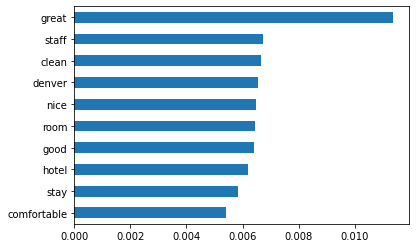

In [47]:
importances_2 = pd.Series(full_pipe.named_steps['clf'].feature_importances_, index = word_cols_2)
importances_2.sort_values().tail(10).plot(kind='barh')

In [16]:
# tokenizer = nltk.tokenize.RegexpTokenizer(pattern)
# tokenizer.tokenize()

TypeError: ignored

In [48]:
# Grid search - fit to raw X_train since it will go through the tokenizer

#EXAMPLE FROM LECTURE:

## Make a tokenizer with TweetTokenizer
tokenizer = nltk.tokenize.RegexpTokenizer(pattern)
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize)
## Make params Grid
#### use_idf: True/False
#### tokenizer: None, tokenizer.tokenize
#### criterion: gini, entropy
#### stopwords

params = {'text_pipe__tf_transformer__use_idf':[True, False],
         'text_pipe__count_vectorizer__tokenizer':[None, tokenizer.tokenize],
         'text_pipe__count_vectorizer__stop_words':[None, stopword_list],
         'clf__criterion':['gini', 'entropy']}

## Make and fit grid
grid = GridSearchCV(full_pipe,params,cv=3)
grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        Pipeline(memory=None,
                                                 steps=[('count_vectorizer',
                                                         CountVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='ignore',
                                                                         dtype=<class 'numpy.int64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                                                                         lowercase=True,
                                                                         max_df=1.

In [49]:
# Display best params
display(grid.best_params_)

# Save best pipe (full pipe), best pipe in NOT the model
best_pipe = grid.best_estimator_

{'clf__criterion': 'gini',
 'text_pipe__count_vectorizer__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out

In [50]:
# View best pipe
set_config(display='diagram')
best_pipe

TypeError: ignored

In [ ]:
# get best model params from grid search... how to get best model out of it??, train(fit) best model, isolate best model, THEN pass into evaluate

# Evaluate model
NLP.evaluate_model(best_pipe, X_test, y_test)

TypeError: evaluate_model() missing 3 required positional arguments: 'model', 'images', and 'labels'

In [ ]:
# feature importance
# from NLTK

# get words NLTK
vectorizer.get_feature_names()

# get importances from model (rf in this case), set names as index
importance = pd.Series(rf.feature_importances_,index=vectorizer.get_feature_names())
importance

importance.sort_values(ascending=True).tail(20).plot(kind='barh')

In [ ]:
# get features importance
# from a pipeline

# number features
X_train_pipe.shape

# get names
features = text_pipe.named_steps['count_vectorizer'].get_feature_names()

# preview
features[:10]

#
len(features)